In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot  as plt
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib as mpl
mpl.rc('font',family='Segoe UI Emoji')

from sklearn import metrics
import itertools

import nltk
nltk.download('twitter_samples')
nltk.download('stopwords')

C:\R-vs-Python\R-vs-Python\venv\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\games\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\games\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import string
import re
 
from nltk.corpus import stopwords 
stopwords_german = stopwords.words('german')
 
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('german')
 
from nltk.tokenize import TweetTokenizer
 
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)
 
def clean_tweets(tweet):
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
 
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
 
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/[^\s]*', '', tweet)
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
    # replace years with 'ayearzzz'-Token
    tweet = re.sub(r'([1-2][0-9]{3})', r'ayearzzz', tweet)
    
    # replace numbers with 'anumberzzz'-Token, only numbers outside of words
    tweet = re.sub(r'(?<![0-9a-zA-Z])[0-9]+(?![0-9a-zA-Z])', r'anumberzzz', tweet)
 
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_german and # remove stopwords
              word not in emoticons and # remove emoticons
                word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            stem_word = stemmer.stem(word) # stemming word
            tweets_clean.append(stem_word)
    tweets_clean=" ".join(tweets_clean)
    
    # remove numbers that were pulled out of words by tokenizer
    tweets_clean = re.sub(r'(?<![0-9a-zA-Z])[0-9]+(?![0-9a-zA-Z])', r'', tweets_clean)
    
    return tweets_clean
 
example_tweet = "RT 10 @Twitter @chapagain Hallo zusammen! $GE Habt einen tollen 19. Oktober 2018 und viel Spaß.  :) #good #morning http://chapagain.com.np"

# print cleaned tweet
print (clean_tweets(example_tweet))

anumberzzz hallo zusamm habt toll anumberzzz oktob ayearzzz spass good morning


In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontname='Segoe UI Emoji')
    plt.yticks(tick_marks, classes, fontname='Segoe UI Emoji')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [4]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [5]:
def plot_important_words_multi_class(importance, class_labels, name):
    for i in range(len(importance)):
        top_scores = [a[0] for a in importance[i]['tops']]
        top_words = [a[1] for a in importance[i]['tops']]
        
        y_pos = np.arange(len(top_words))
        top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
        top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
        top_words = [a[0] for a in top_pairs]
        top_scores = [a[1] for a in top_pairs]
        
        subplot = str(int(len(importance)/2)+1)+str(2)+str(i + 1)
        plt.subplot(int(len(importance)/2)+1, 2, i + 1)
        plt.barh(y_pos,top_scores, align='center', alpha=0.5)
        plt.title(class_labels[i], fontsize=20, fontname='Segoe UI Emoji')
        plt.yticks(y_pos, top_words, fontsize=14)
        plt.suptitle(name, fontsize=16)
        plt.xlabel('Importance', fontsize=14)
    
    plt.subplots_adjust(wspace=0.8, hspace=0.6)
    

End of definitions

------------------

Start data preparation



In [6]:
importdf=pd.read_csv('../../data/trainingssets/all_emoji_tweets_03_12_18_7_labels_excluded.csv', sep =';', usecols=['tweet_full_text', 'target'])
importdf.dropna(inplace=True)
importdf.reset_index(inplace=True, drop=True)

In [7]:
all_targets = importdf['target'].astype(str).values.tolist()

In [8]:
y=[]
for i in range(len(all_targets)):
    #Only use first emoji per tweet for now
    y.append(all_targets[i].split(',')[0])

# for filtering in conversion to binary classification later on
dfy=pd.DataFrame(y)
dfx=pd.DataFrame(importdf['tweet_full_text'])
dfx.columns = range(dfx.shape[1])

In [9]:
# convert to binary classification
binary_labels=['😭','♥️']   # two Labels chosen for binary classification
multi_class_labels=['😂','♥️','🤔','💪','🙄']

dfy=dfy[dfy.isin(multi_class_labels)]
dfy.dropna(inplace=True)
dfx=dfx[dfy.isin(multi_class_labels)]
dfx.dropna(inplace=True)

df=dfx.copy()
df.rename(inplace=True, columns={0: "tweet"})
df['target'] = dfy

'''# BINARY CASE: balance classes to 50:50 by dropping appropriate (randomized) fraction of majority class
majority_class='♥️'
class_freq=df['target'].value_counts()
df = df.drop(df[df['target'] == majority_class].sample(frac=(1-class_freq[1]/class_freq[0]), random_state=123).index)'''

# MULTICLASS CASE: balance classes by dropping rows from all majority classes to length of minority class
minority_class_len=(df['target'].value_counts())[-1] # set to id of minority class
majority_classes=(df['target'].value_counts()).index[0:4]
for label in majority_classes:
    df = df.drop(df[df['target'] == label].sample(n=(df['target'].value_counts().loc[label]-minority_class_len), random_state=123).index)

# prepare data for following steps
our_tweets=df['tweet'].astype(str).values.tolist()
y=df['target'].astype(str).values.tolist()

In [10]:
corpus=[]
for i in range(len(our_tweets)):
    corpus.append(clean_tweets(our_tweets[i]))
corpus[0:5]

['hahaha kosting damal eu-richtlini reduktion plastiksackerln gestimmt jaja weiss dass eu-richtlin reduktion gesetz komplett verbot bringt trotzd',
 'kart letzt jahr onkel mathelehr papa mathelehr geschickt',
 'lieb neu handy hull',
 'verknupft spanisch radikalnationalismus bevolker spani verbind einzeln region ungewohn gerad eher linksnational kataloni denkt vox',
 'gut abend best follow welt lasst druck knutsch ubrig nucht knutschbedurft panik elch streck schon armch …']

In [11]:
combined_df = pd.DataFrame({"tweets" : corpus, "targets": y})
combined_df.shape

(57495, 2)

In [12]:
%load_ext rpy2.ipython

In [13]:
%%R -i combined_df
#install.packages("dplyr")
#install.packages("ggplot2")

library(dplyr)
library(tidytext)
tweet_words <- combined_df %>%
  unnest_tokens(word, tweets) %>%
  count(targets, word, sort = TRUE) %>%
  ungroup()

total_words <- tweet_words %>% 
  group_by(targets) %>% 
  summarize(total = sum(n))

tweet_words <- left_join(tweet_words, total_words)

C:\R-vs-Python\R-vs-Python\venv\lib\site-packages\rpy2-2.9.4-py3.7-win-amd64.egg\rpy2\robjects\pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [14]:
%R -o tweet_words
tweet_words

targets,word,n,total
'💪','anumberz...,"5,988","118,293"
'🙄','anumberz...,"2,491","110,339"
'🤔','anumberz...,"2,438","109,134"
'♥️','anumberz...,"2,428","104,316"
...,...,...,...
'♥️','zwoa',1,"104,316"
'♥️','zwolfband',1,"104,316"
'♥️','zynisch',1,"104,316"
'♥️','zz',1,"104,316"


In [15]:
%%R -o tweet_words
tweet_words <- tweet_words %>%
  bind_tf_idf(word, targets, n) %>%
  arrange(desc(tf_idf))

In [16]:
tweet_words

targets,word,n,total,tf,idf,tf_idf
'💪','hotrolli...,47,"118,293",0.000397,1.609438,0.000639
'♥️','sicheng',34,"104,316",0.000326,1.609438,0.000525
'💪','u19',38,"118,293",0.000321,1.609438,0.000517
'💪','rbbl',33,"118,293",0.000279,1.609438,0.000449
...,...,...,...,...,...,...
'♥️','zusammen...,1,"104,316",0.000010,0.000000,0.000000
'♥️','zutat',1,"104,316",0.000010,0.000000,0.000000
'♥️','zwilling',1,"104,316",0.000010,0.000000,0.000000
'♥️','zwing',1,"104,316",0.000010,0.000000,0.000000


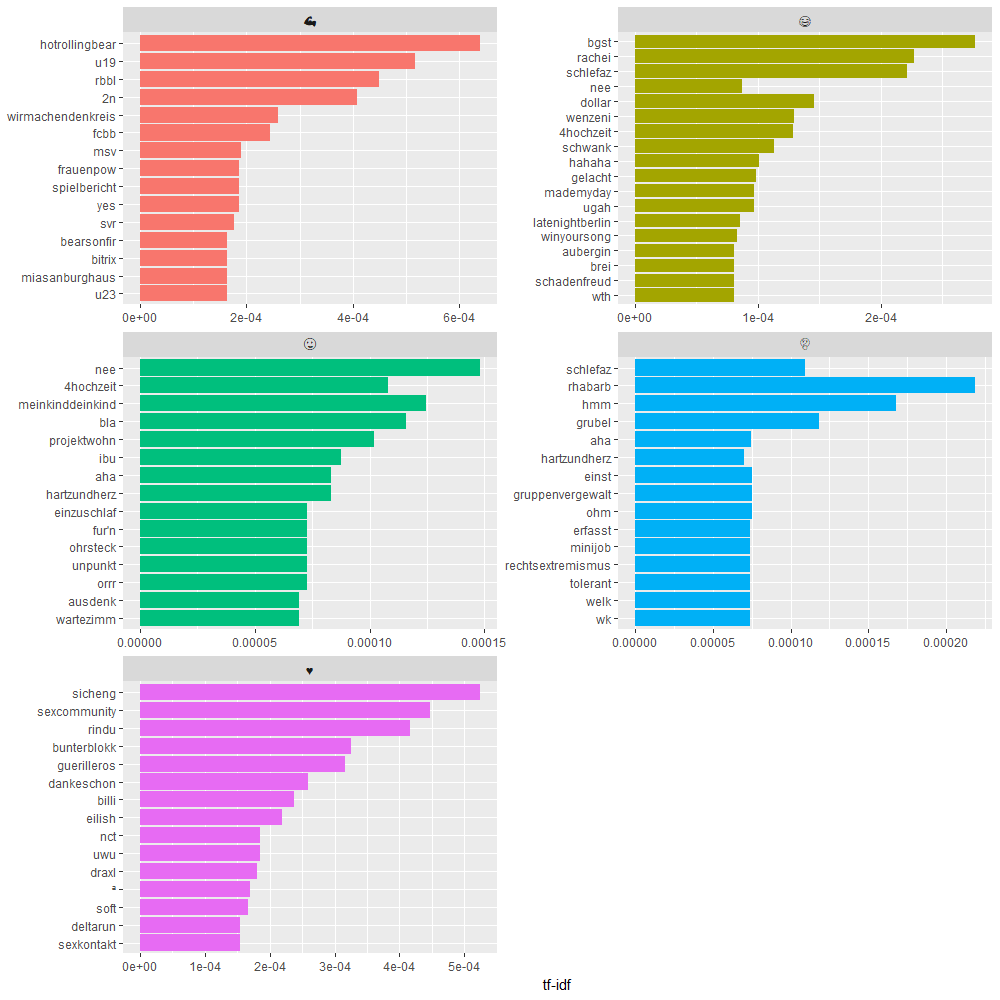

In [17]:
%%R -o tweet_words -w 1000 -h 1000 -r 100
library(ggplot2)
tweet_words %>%
  arrange(desc(tf_idf)) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>% 
  group_by(targets) %>% 
  top_n(15) %>% 
  ungroup %>% 
  ggplot(aes(word, tf_idf, fill = targets)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~targets, ncol = 2, scales = "free") +
  coord_flip()

Start Advanced SGDClassifier

In [18]:
X_train, X_test, y_train, y_test = train_test_split(corpus, y, test_size=0.4, random_state=0)
pipe_clf = Pipeline([
    ('vect', CountVectorizer(max_df=0.9, min_df=5, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(random_state=0, 
                          max_iter=100, tol=None))
])

parameters = {
     'clf__loss': ['modified_huber', 'log'],
     'clf__penalty': ['elasticnet', 'l2'],
     'clf__alpha': [1e-5],
     'clf__epsilon': [0.01],
     'clf__learning_rate': ['invscaling', 'optimal'],
     'clf__eta0': [10]
     #'clf__eta0': [1e-4, 0.1],
}
gs_clf = GridSearchCV(pipe_clf, parameters, cv=3, iid=False, n_jobs=-1)
gs_clf.fit(X_train, y_train)
predicted = gs_clf.predict(X_test)
np.mean(predicted == y_test)  

C:\R-vs-Python\R-vs-Python\venv\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.47769371249673886

Normalized confusion matrix
[[0.52200569 0.1607182  0.15743376 0.08867966 0.07116269]
 [0.13848491 0.61319731 0.08595615 0.08530497 0.07705665]
 [0.15445757 0.1132116  0.33576799 0.21718582 0.17937701]
 [0.09586957 0.09043478 0.16978261 0.45173913 0.19217391]
 [0.07901072 0.10702561 0.14532721 0.2011381  0.46749836]]


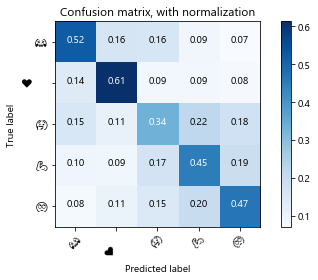

In [19]:
plt.figure()
cnf_matrix = confusion_matrix(y_test, predicted)
plot_confusion_matrix(cnf_matrix, classes=multi_class_labels, normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

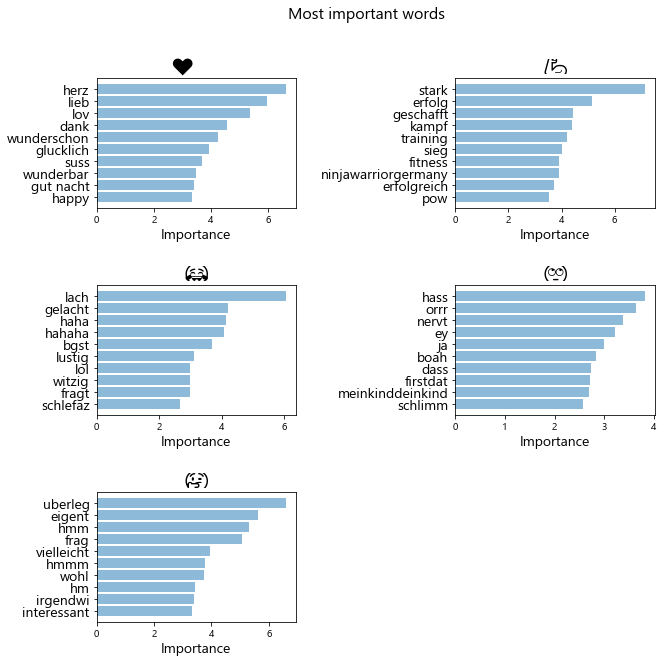

In [20]:
plt.figure(figsize=(10,10))
importance = get_most_important_features(gs_clf.best_estimator_.get_params()['vect'], gs_clf.best_estimator_.get_params()['clf'], 10)
plot_important_words_multi_class(importance, gs_clf.best_estimator_.get_params()['clf'].classes_, "Most important words")
plt.show()